In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
from torchvision import transforms

from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

c:\Users\soseb\OneDrive\Documents\ViT-Paper-Replication\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cpu"

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [5]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir,
    test_dir,
    manual_transforms,
    BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2088afd6120>,
 ['pizza', 'steak', 'sushi'])

In [6]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

c:\Users\soseb\OneDrive\Documents\ViT-Paper-Replication\.venv\Lib\site-packages\torch\utils\data\dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


(torch.Size([3, 224, 224]), tensor(0))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

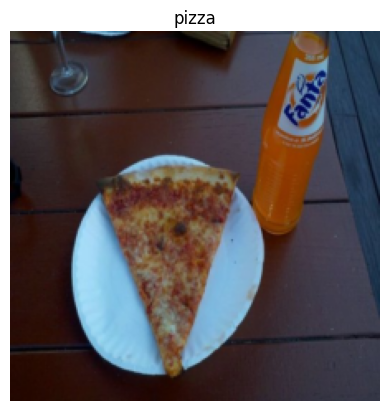

In [7]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [8]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height*width) / patch_size**2)
number_of_patches

196

In [9]:
embedding_layer_input_shape = (height, width, color_channels)

embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

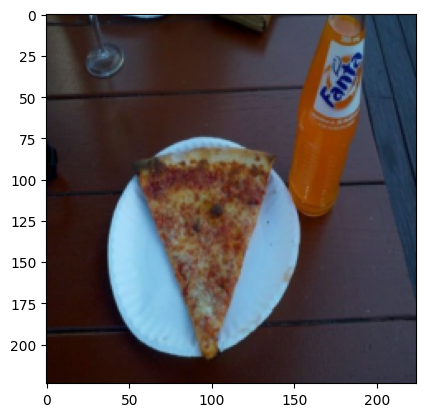

In [10]:
plt.imshow(image.permute(1, 2, 0))

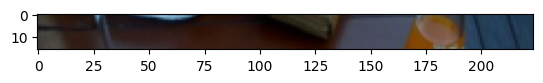

In [11]:
image_permuted = image.permute(1, 2, 0)

plt.Figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


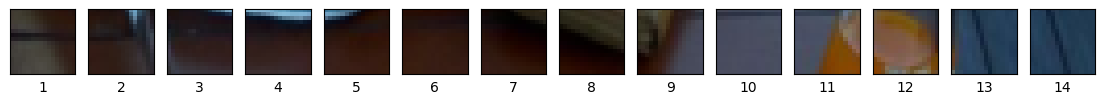

In [12]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [13]:
from torch import nn
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

In [14]:
image.shape

torch.Size([3, 224, 224])

In [15]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


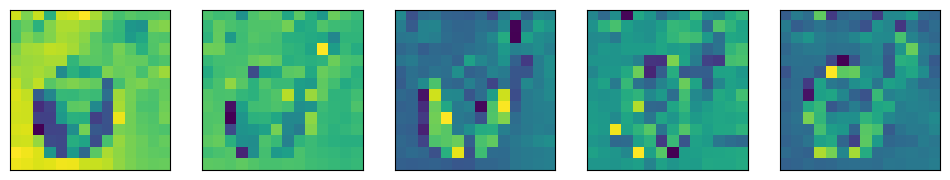

In [16]:
import random 
random_indexes = random.sample(range(0, 758), k=5)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [18]:
print(f"Current tensor shape: {image_out_of_conv.shape}")

Current tensor shape: torch.Size([1, 768, 14, 14])


In [19]:
flatten = nn.Flatten(start_dim=2, end_dim=3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


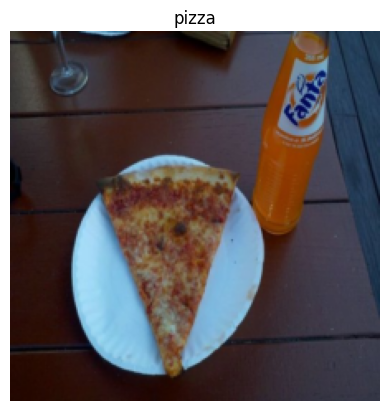

In [20]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [21]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape}")

Patch embedding sequence shape: torch.Size([1, 196, 768])


In [22]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3, patch_size: int=16, embedding_dim: int=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1)

In [24]:
set_seeds()

patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [26]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)



In [27]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)


In [29]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [30]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

In [31]:
set_seeds()

patch_size = 16

height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)


patch_embedding = patch_embedding_layer(x)

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)

number_of_patches = int((height*width)/patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension), requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Patch and position embedding shape: torch.Size([1, 197, 768])
